In [4]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [5]:
DATADIR = r"D:\dataset\FruitClassificationDataset\train\train"
dataset = ImageFolder(DATADIR, transform=ToTensor())

In [6]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 100, 100]) 0


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [7]:
print(dataset.classes)

['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']


In [8]:
random_seed = 42
torch.manual_seed(random_seed)
val_size = 0.1
train_size = len(dataset) - val_size
print(train_size)
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

16853.9


TypeError: randperm() received an invalid combination of arguments - got (float, generator=torch._C.Generator), but expected one of:
 * (int n, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int n, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [22]:
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [7]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

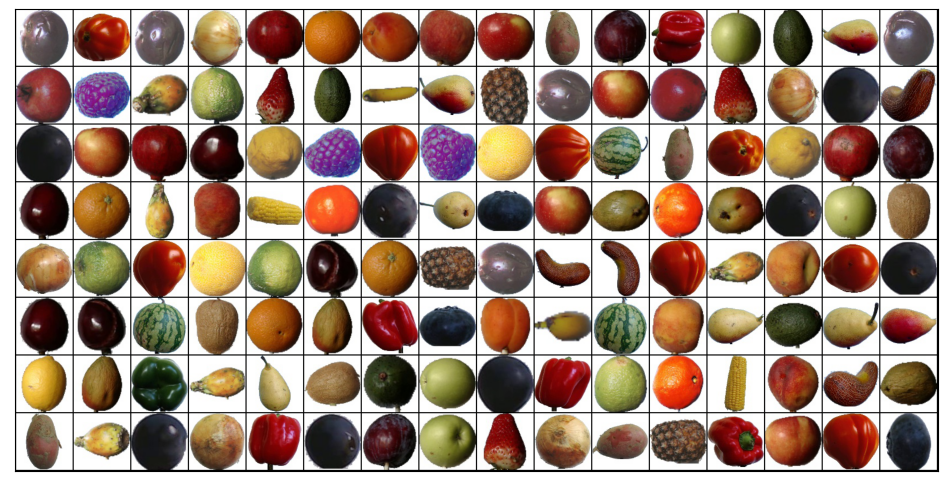

In [23]:
show_batch(train_dl)

In [5]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [6]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 50 x 50

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 25 x 25

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 12 x 12
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 6 x 6
            
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 1024 x 3 x 3
            
            
            nn.Flatten(), 
            nn.Linear(1024*3*3, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 33))
        
    def forward(self, xb):
        return self.network(xb)

In [36]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [54]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=36864, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [37]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        print("epoch ",epoch)
        model.train()
        train_losses = []
        i = 0
        for batch in train_loader:
            print("bacth no: ",i)
            i+=1
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        print("validation starts")
        result = evaluate(model, val_loader)
        print("validation ends")
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [39]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

epoch  0
bacth no:  0
bacth no:  1
bacth no:  2
bacth no:  3
bacth no:  4
bacth no:  5
bacth no:  6
bacth no:  7
bacth no:  8
bacth no:  9
bacth no:  10
bacth no:  11
bacth no:  12
bacth no:  13
bacth no:  14
bacth no:  15
bacth no:  16
bacth no:  17
bacth no:  18
bacth no:  19
bacth no:  20
bacth no:  21
bacth no:  22
bacth no:  23
bacth no:  24
bacth no:  25
bacth no:  26
bacth no:  27
bacth no:  28
bacth no:  29
bacth no:  30
bacth no:  31
bacth no:  32
bacth no:  33
bacth no:  34
bacth no:  35
bacth no:  36
bacth no:  37
bacth no:  38
bacth no:  39
bacth no:  40
bacth no:  41
bacth no:  42
bacth no:  43
bacth no:  44
bacth no:  45
bacth no:  46
bacth no:  47
bacth no:  48
bacth no:  49
bacth no:  50
bacth no:  51
bacth no:  52
bacth no:  53
bacth no:  54
bacth no:  55
bacth no:  56
bacth no:  57
bacth no:  58
bacth no:  59
bacth no:  60
bacth no:  61
bacth no:  62
bacth no:  63
bacth no:  64
bacth no:  65
bacth no:  66
bacth no:  67
bacth no:  68
bacth no:  69
bacth no:  70
bacth n

In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

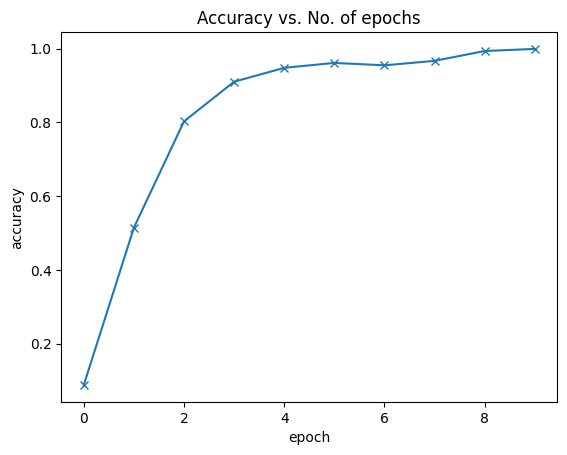

In [41]:
plot_accuracies(history)

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

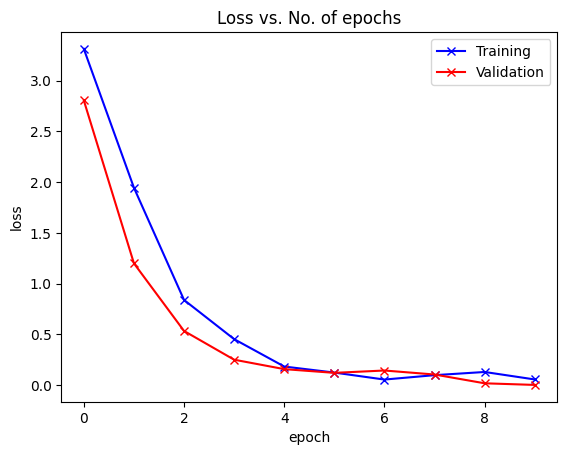

In [43]:
plot_losses(history)

In [10]:
test_dir = r"D:\dataset\FruitClassificationDataset\test"
test_dataset = ImageFolder(test_dir, transform=ToTensor())


In [50]:
test_dataset[0]

(tensor([[[0.9569, 0.9647, 0.9804,  ..., 1.0000, 1.0000, 1.0000],
          [0.9725, 0.9804, 0.9843,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.9961, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.9922, 0.9804,  ...,

In [12]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Predicted: Orange


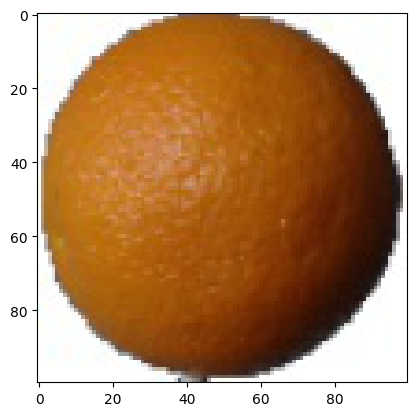

In [63]:
img, label = test_dataset[500]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

In [64]:
# for saving model
FILE = "model.pth"
torch.save(model.state_dict(),FILE)

In [65]:
print(history)

[{'val_loss': 2.8050906658172607, 'val_acc': 0.08846507221460342, 'train_loss': 3.3126611709594727}, {'val_loss': 1.2002763748168945, 'val_acc': 0.5148322582244873, 'train_loss': 1.945315957069397}, {'val_loss': 0.5340510606765747, 'val_acc': 0.8029411435127258, 'train_loss': 0.8395130038261414}, {'val_loss': 0.2509399354457855, 'val_acc': 0.9103285670280457, 'train_loss': 0.4534991681575775}, {'val_loss': 0.15803097188472748, 'val_acc': 0.947966456413269, 'train_loss': 0.1835109293460846}, {'val_loss': 0.12128239870071411, 'val_acc': 0.9612706899642944, 'train_loss': 0.12405294924974442}, {'val_loss': 0.14436718821525574, 'val_acc': 0.9547794461250305, 'train_loss': 0.055229686200618744}, {'val_loss': 0.10498601198196411, 'val_acc': 0.9668198823928833, 'train_loss': 0.09853515028953552}, {'val_loss': 0.018370218575000763, 'val_acc': 0.9935547113418579, 'train_loss': 0.12989550828933716}, {'val_loss': 0.0023803135845810175, 'val_acc': 0.999218761920929, 'train_loss': 0.0562152825295925

In [77]:
for dic in history:
    print(dic)

{'val_loss': 2.8050906658172607, 'val_acc': 0.08846507221460342, 'train_loss': 3.3126611709594727}
{'val_loss': 1.2002763748168945, 'val_acc': 0.5148322582244873, 'train_loss': 1.945315957069397}
{'val_loss': 0.5340510606765747, 'val_acc': 0.8029411435127258, 'train_loss': 0.8395130038261414}
{'val_loss': 0.2509399354457855, 'val_acc': 0.9103285670280457, 'train_loss': 0.4534991681575775}
{'val_loss': 0.15803097188472748, 'val_acc': 0.947966456413269, 'train_loss': 0.1835109293460846}
{'val_loss': 0.12128239870071411, 'val_acc': 0.9612706899642944, 'train_loss': 0.12405294924974442}
{'val_loss': 0.14436718821525574, 'val_acc': 0.9547794461250305, 'train_loss': 0.055229686200618744}
{'val_loss': 0.10498601198196411, 'val_acc': 0.9668198823928833, 'train_loss': 0.09853515028953552}
{'val_loss': 0.018370218575000763, 'val_acc': 0.9935547113418579, 'train_loss': 0.12989550828933716}
{'val_loss': 0.0023803135845810175, 'val_acc': 0.999218761920929, 'train_loss': 0.056215282529592514}


In [100]:
#for saving history
import pickle
with open('saved_list.pkl', 'wb') as f:
    pickle.dump(history, f)
        
with open('saved_list.pkl', 'rb') as f:
    loaded_list_of_dicts = pickle.load(f)

In [101]:
loaded_list_of_dicts

[{'val_loss': 2.8050906658172607,
  'val_acc': 0.08846507221460342,
  'train_loss': 3.3126611709594727},
 {'val_loss': 1.2002763748168945,
  'val_acc': 0.5148322582244873,
  'train_loss': 1.945315957069397},
 {'val_loss': 0.5340510606765747,
  'val_acc': 0.8029411435127258,
  'train_loss': 0.8395130038261414},
 {'val_loss': 0.2509399354457855,
  'val_acc': 0.9103285670280457,
  'train_loss': 0.4534991681575775},
 {'val_loss': 0.15803097188472748,
  'val_acc': 0.947966456413269,
  'train_loss': 0.1835109293460846},
 {'val_loss': 0.12128239870071411,
  'val_acc': 0.9612706899642944,
  'train_loss': 0.12405294924974442},
 {'val_loss': 0.14436718821525574,
  'val_acc': 0.9547794461250305,
  'train_loss': 0.055229686200618744},
 {'val_loss': 0.10498601198196411,
  'val_acc': 0.9668198823928833,
  'train_loss': 0.09853515028953552},
 {'val_loss': 0.018370218575000763,
  'val_acc': 0.9935547113418579,
  'train_loss': 0.12989550828933716},
 {'val_loss': 0.0023803135845810175,
  'val_acc': 0.99

In [8]:
#for loading saved model
FILE = "model.pth"
load_model = Cifar10CnnModel()
load_model.load_state_dict(torch.load(FILE))
load_model.eval()

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=

Predicted: Orange


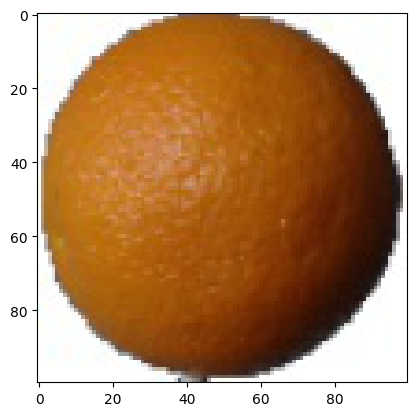

In [15]:
img, label = test_dataset[500]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, load_model))

In [20]:
import pickle
dataset.classes
with open('dataset_classes.pkl', 'wb') as f:
    pickle.dump(dataset.classes, f)

with open('dataset_classes.pkl', 'rb') as f:
    dataset_classes = pickle.load(f)

In [21]:
dataset_classes

['Apple Braeburn',
 'Apple Granny Smith',
 'Apricot',
 'Avocado',
 'Banana',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe',
 'Cherry',
 'Clementine',
 'Corn',
 'Cucumber Ripe',
 'Grape Blue',
 'Kiwi',
 'Lemon',
 'Limes',
 'Mango',
 'Onion White',
 'Orange',
 'Papaya',
 'Passion Fruit',
 'Peach',
 'Pear',
 'Pepper Green',
 'Pepper Red',
 'Pineapple',
 'Plum',
 'Pomegranate',
 'Potato Red',
 'Raspberry',
 'Strawberry',
 'Tomato',
 'Watermelon']